### 3. MNIST and CNN Experiments [3 marks]

This section explores deep learning for images. You will train MLPs and CNNs on MNIST, compare performance against baseline models, visualize embeddings using t-SNE, and test cross-domain generalization on Fashion-MNIST.

#### 3.1 Using MLP [1.5 marks]
Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images but keep the same test set. Your MLP has 30 neurons in the first layer, 20 in the second layer and then 10 finally for the output layer (corresponding to 10 classes)
Report the following:
- Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix. Write your observations and discuss misclassifications.
- Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.
- Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.


#### Basic Imports


In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from keras.datasets import mnist, fashion_mnist
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
np.random.seed(42)

#### Loading the dataset

In [11]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape(-1, 28 * 28)
test_X = test_X.reshape(-1, 28 * 28)

train_X = torch.from_numpy(train_X).float().reshape(-1, 28 * 28) / 255
train_y = torch.from_numpy(train_y).long()

test_X = torch.from_numpy(test_X).float().reshape(-1, 28 * 28) / 255
test_y = torch.from_numpy(test_y).long()

#### Utility functions

In [ ]:
def print_metrics(model):

    model.eval()
    # Use no gradient for evaluation
    with torch.no_grad():
		
        # Move test data to MPS
        test_X_mps = test_X.to('mps')
        test_y_mps = test_y.to('mps')

        # Forward pass
        outputs = model(test_X_mps)
        _, pred = torch.max(outputs, 1)

        # Move results back to CPU for sklearn & numpy
        y_true = test_y_mps.cpu().numpy()
        y_pred = pred.cpu().numpy()

        # Accuracy
        acc = (pred == test_y_mps).float().mean()
        print(f"Accuracy: {acc.item():.4f}")

        # Confusion matrix & F1
        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average=None)

        # Precision & recall per class
        precisions = []
        recalls = []
        for i in range(10):
            precisions.append(cm[i, i] / (cm[:, i].sum() + 1e-7))
            recalls.append(cm[i, i] / (cm[i].sum() + 1e-7))

        # Table
        df = pd.DataFrame(
            np.array([f1, precisions, recalls]).T,
            index=range(10),
            columns=["F1 Score", "Precision", "Recall"]
        )
        df.index.name = "Class"
        display(df.T)

        # Heatmap
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        return cm

# Metrics for Random Forest as it uses numpy arrays and not tensors
def print_metrics_rf(model):

    y_pred = model.predict(test_X)
    y_true = test_y

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)

    # Precision and recall per class
    precisions = []
    recalls = []
    for i in range(10):
        precisions.append(cm[i, i] / (cm[:, i].sum() + 1e-7))
        recalls.append(cm[i, i] / (cm[i].sum() + 1e-7))

    df = pd.DataFrame(
        np.array([f1, precisions, recalls]).T,
        index=range(10),
        columns=["F1 Score", "Precision", "Recall"]
    )
    df.index.name = "Class"
    display(df.T)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"Accuracy: {acc:.4f}")
    return cm

 
def plot_losses(losses):
	plt.plot(losses)
	plt.title("Losses")
	plt.xlabel("Epoch")
	plt.ylabel("Loss") 
 
def train(model, lr=0.01, epochs=100, verbose=False, optimizer='adam', reg=0, **kwargs):
	loss = nn.CrossEntropyLoss()
	optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg) if optimizer == 'adam' else torch.optim.SGD(model.parameters(), lr=lr)
	
	losses = []
	for i in range(epochs):
		optim.zero_grad()
		pred = model(train_X, **kwargs)
		l = loss(pred, train_y)
		l.backward()
		optim.step()
		losses.append(l.item())
  
		if verbose and i % (epochs//10) == 0:
			print(f"Epoch {i} Loss: {l.item()}")
  
	return losses

def plot_tsne(model):
	
    X_tensor = torch.tensor(train_X, dtype=torch.float32).to('cpu')
    feats = model.get_feats(X_tensor)
    
    for i in range(len(feats)):
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(feats[i])
        plt.figure(figsize=(6, 6))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_y, cmap="tab10")
        legend_labels = [f"Class {label}" for label in range(10)]
        plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
        plt.title(f"Layer {i + 1} T-SNE")
        plt.show()

### Training and comparing the performance of MLP, Random Forest and Logistic Regression for the Handwritten digits classification task

In this section, we train the model on the MNIST dataset and compare the performance of MLP, Random Forest and Logistic Regression models. We will use the F1-score and confusion matrix as the metrics to compare the models.

The dataset consists of 60,000 training images and 10,000 test images.

#### Training the MLP model
In this section, we train a simple MLP for the MNIST handwritten digits dataset. The architecture of the MLP is as follows:
- Input: 784  
- Hidden1: 30  
- Hidden2: 20  
- Output: 10

We use the Adam optimizer and the cross-entropy loss function. The activation function used is sigmoid for the hidden layers and softmax for the output layer. However, we haven't explicitly passed the output through the softmax function since the loss function expects logits.

At the end we see the commonly miscalssified digits. We also plot a few of them and see that they are actually very similar looking to the misclassified digit.

In [13]:
class MLP(nn.Module):
    def __init__(self, act=nn.Sigmoid()):
        super().__init__()
        self.act = act
        self.l1 = nn.Linear(28 * 28, 30)
        self.l2 = nn.Linear(30, 20) # hidden layer
        self.l3 = nn.Linear(20, 10)  # output layer

    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        # we ignore the softmax layer here, because we will be predicting the logits, because Cross Entropy Loss in PyTorch expects logits as input.
        return x

    def predict(self, x):
        return self.forward(x).argmax(dim=1)


In [ ]:
# Move model and data to mps for faster training
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = MLP(act=nn.Sigmoid()).to(device)

train_X, train_y = train_X.to(device), train_y.to(device)
test_X, test_y = test_X.to(device), test_y.to(device)

In [15]:
losses = train(model, lr=0.001, epochs=5000, verbose=True, reg=1e-5)

Epoch 0 Loss: 2.362215518951416
Epoch 500 Loss: 0.5444619655609131
Epoch 1000 Loss: 0.2427852600812912
Epoch 1500 Loss: 0.15192076563835144
Epoch 2000 Loss: 0.10529469698667526
Epoch 2500 Loss: 0.07582546025514603
Epoch 3000 Loss: 0.05564165860414505
Epoch 3500 Loss: 0.04142031818628311
Epoch 4000 Loss: 0.03142649307847023
Epoch 4500 Loss: 0.02429872564971447


In [ ]:
os.makedirs('./models', exist_ok=True)
torch.save(model.to('cpu'), './models/mlp_ours.pth')
# Saving the trained model, so that I don't have to train it again

 The loss curve, and evaluating the model on the test set

Accuracy: 0.9604


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.974645,0.982857,0.954745,0.952193,0.958695,0.945719,0.967170,0.962530,0.950026,0.951147
Accuracy,0.968750,0.980702,0.958944,0.947988,0.960163,0.944134,0.965661,0.962999,0.953464,0.956871
Recall,0.980612,0.985022,0.950581,0.956436,0.957230,0.947309,0.968685,0.962062,0.946612,0.945491


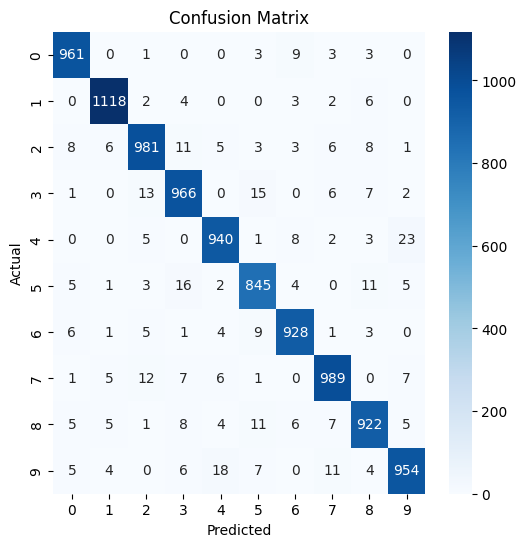

Most commonly confused with 0: [6 8]
Most commonly confused with 1: [8 3]
Most commonly confused with 2: [3 8]
Most commonly confused with 3: [5 2]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [3 8]
Most commonly confused with 6: [5 0]
Most commonly confused with 7: [2 9]
Most commonly confused with 8: [5 3]
Most commonly confused with 9: [4 7]


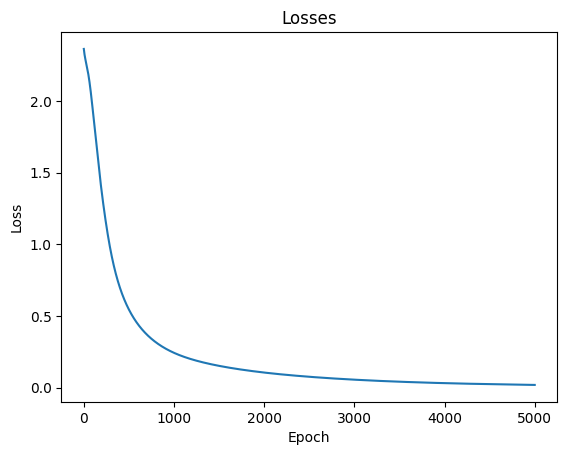

In [24]:
model = model.to('mps')
cm = print_metrics(model)
plot_losses(losses)

for i in range(10):
	print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

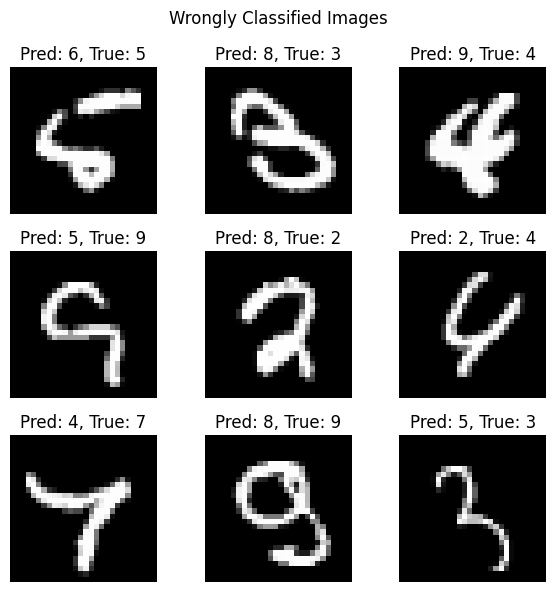

In [25]:
model.eval() 

with torch.no_grad():  # Use no grad for evaluation

    test_X_mps = test_X.to('mps')
    test_y_mps = test_y.to('mps')

    outputs = model(test_X_mps)
    _, pred = torch.max(outputs, 1)  # take index of highest score

    pred = pred.cpu()
    test_y_cpu = test_y_mps.cpu()
    test_X_cpu = test_X.cpu()

    # wrong samples
    wrong_mask = pred != test_y_cpu
    wrong = test_X_cpu[wrong_mask]
    wrong_pred = pred[wrong_mask]
    wrong_true = test_y_cpu[wrong_mask]

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax[i, j].imshow(wrong[idx].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f"Pred: {wrong_pred[idx].item()}, True: {wrong_true[idx].item()}")
        ax[i, j].axis('off')

plt.suptitle("Wrongly Classified Images")
plt.tight_layout()
plt.show()


#### Training the Logistic Regression model

In this section, we train a Logistic Regression model for the MNIST handwritten digits dataset. Again the model is trained for 5000 epochs, with a learning rate of 3e-4 and the Loss used is the cross-entropy loss.

In [26]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28 * 28, 10)

    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [27]:
model = LogisticRegression().to('mps')
losses = train(model, lr=3e-4, epochs=5000, verbose=True)

Epoch 0 Loss: 2.2913591861724854
Epoch 500 Loss: 0.5344845652580261
Epoch 1000 Loss: 0.39284539222717285
Epoch 1500 Loss: 0.3394052982330322
Epoch 2000 Loss: 0.31017741560935974
Epoch 2500 Loss: 0.2911836504936218
Epoch 3000 Loss: 0.27755457162857056
Epoch 3500 Loss: 0.267142117023468
Epoch 4000 Loss: 0.2588422894477844
Epoch 4500 Loss: 0.2520228624343872


In [28]:
# Save the trained model
os.makedirs('models', exist_ok=True)
torch.save(model, './models/lr.pth')

##### The loss curve, and evaluating the model on the test set

Accuracy: 0.9267


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.967221,0.973730,0.913495,0.910979,0.932859,0.891938,0.947260,0.923527,0.885396,0.910626
Accuracy,0.956132,0.967798,0.932392,0.910079,0.931911,0.910152,0.938525,0.924878,0.874749,0.912438
Recall,0.978571,0.979736,0.895349,0.911881,0.933809,0.874439,0.956159,0.922179,0.896304,0.908821


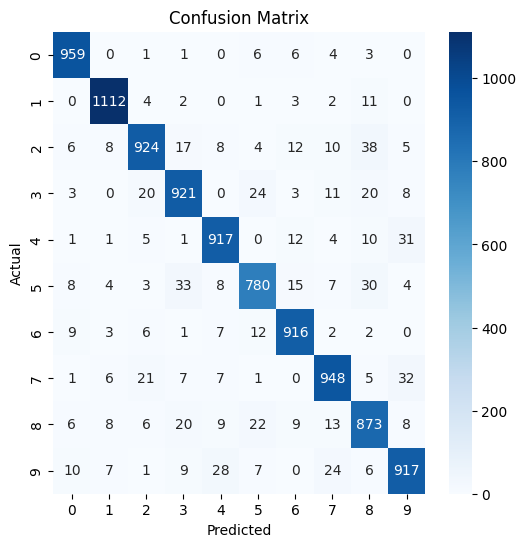

Most commonly confused with 0: [6 5]
Most commonly confused with 1: [8 2]
Most commonly confused with 2: [8 3]
Most commonly confused with 3: [5 8]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [3 8]
Most commonly confused with 6: [5 0]
Most commonly confused with 7: [9 2]
Most commonly confused with 8: [5 3]
Most commonly confused with 9: [4 7]


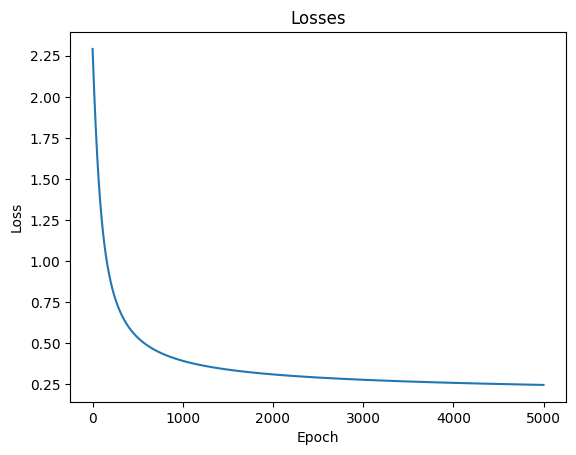

In [29]:
cm = print_metrics(model)
plot_losses(losses)

for i in range(10):
	print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

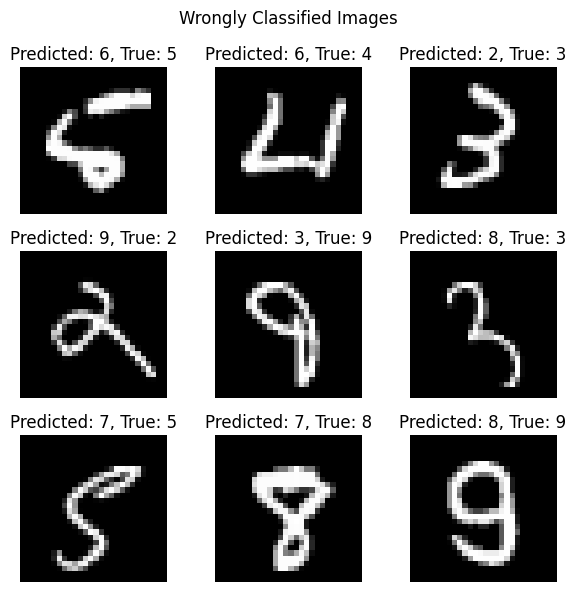

In [31]:
pred = model.predict(test_X)
wrong = test_X[pred != test_y]
wrong_pred = pred[pred != test_y]
wrong_true = test_y[pred != test_y]

wrong = wrong.cpu()
wrong_pred = wrong_pred.cpu()
wrong_true = wrong_true.cpu()

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(wrong[i * 3 + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f"Predicted: {wrong_pred[i * 3 + j]}, True: {wrong_true[i * 3 + j]}")
        ax[i, j].axis('off')
fig.suptitle("Wrongly Classified Images")
fig.tight_layout()


#### Training a Random Forest

In this section, we train a Random Forest model for the MNIST handwritten digits dataset. We use 100 trees in the Random Forest model, with a maximum depth of 32. The impurity function used is the Gini impurity. After training the model, we evaluate it on the test set and get the following results.

In [ ]:
# Move data back to CPU for sklearn
train_X = train_X.cpu().numpy()
train_y = train_y.cpu().numpy()
test_X = test_X.cpu().numpy()
test_y = test_y.cpu().numpy()

Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.980253,0.989872,0.961928,0.961348,0.974464,0.964627,0.976017,0.965787,0.953751,0.954274
Accuracy,0.972864,0.989437,0.956855,0.962302,0.977459,0.966254,0.975000,0.970530,0.954733,0.957129
Recall,0.987755,0.990308,0.967054,0.960396,0.971487,0.963004,0.977035,0.961089,0.952772,0.951437


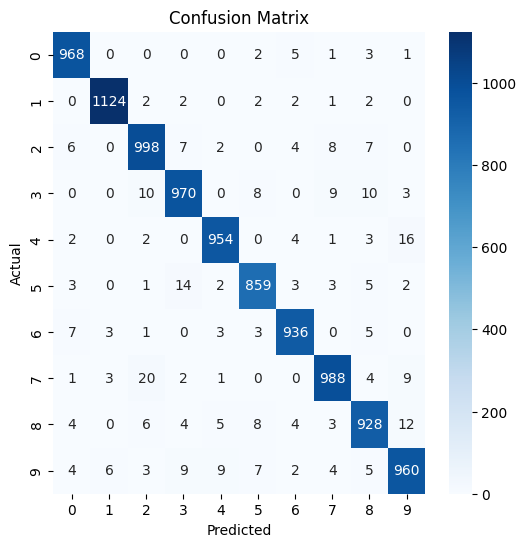

Accuracy: 0.9685
Most commonly confused with 0: [6 8]
Most commonly confused with 1: [8 6]
Most commonly confused with 2: [7 8]
Most commonly confused with 3: [8 2]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [3 8]
Most commonly confused with 6: [0 8]
Most commonly confused with 7: [2 9]
Most commonly confused with 8: [9 5]
Most commonly confused with 9: [4 3]


In [35]:
rf = RandomForestClassifier(n_estimators=100, max_depth=32, criterion='gini')
rf.fit(train_X, train_y)

cm = print_metrics_rf(rf)

for i in range(10):
	print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

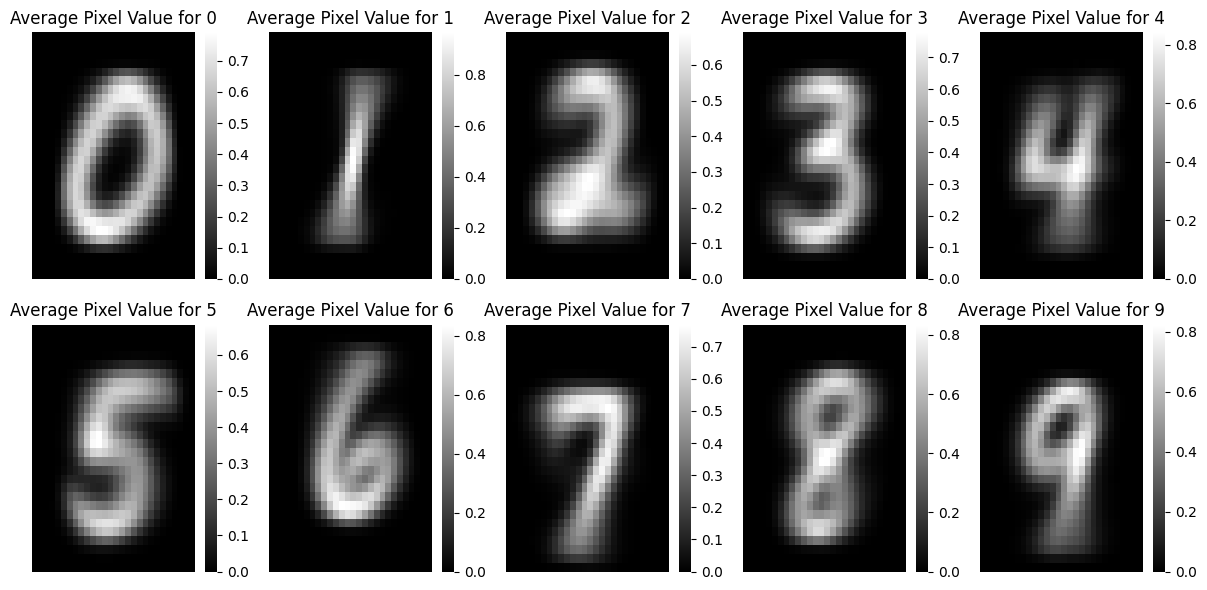

In [36]:
# plot the average pixel value for each class
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sns.heatmap(train_X[train_y == i].reshape(-1, 28, 28).mean(0), cmap="gray")
    plt.title("Average Pixel Value for " + str(i))
    plt.axis('off')
plt.tight_layout()

The results are as follows:

| **Model** | **Accuracy** | **Avg. F1 Score** |
|:------|:---------:|:---------:|
| MLP (Multilayer Perceptron) | 0.9604 | 0.9600 |
| Logistic Regression | 0.9267 | 0.9257 |
| Random Forest | 0.9685 | 0.9682 |

The Random Forest model performs the best among the three, slightly outperforming the MLP.  
This is likely because the digits in the MNIST dataset are centered and scaled, which helps tree-based models like Random Forest classify effectively.  

The MLP also performs competitively, demonstrating that neural networks can capture complex nonlinear patterns. Meanwhile, Logistic Regression, being a linear model, performs slightly worse on this dataset.

### Visualizing the t-SNE Embeddings for Different Layers of the MLP Model

In this section, we visualize the t-SNE embeddings for the outputs of the hidden layers of the MLP model.

#### MLP Architecture
- Input layer: 784 neurons  
- Hidden layer 1: 30 neurons  
- Hidden layer 2: 20 neurons  
- Output layer: 10 neurons  

We first visualize the t-SNE embeddings of the untrained model and then the trained model.  

In [38]:
class MLP(nn.Module):
    def __init__(self, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 30)   
        self.l2 = nn.Linear(30, 20)
        self.l3 = nn.Linear(20, 10)
        self.act = act

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        return x  # logits (no softmax, since CrossEntropyLoss expects logits)

    def predict(self, x):
        return self.forward(x).argmax(dim=1)

    # Return activations after each layer (for visualization).
    def get_feats(self, x):
        feats = []
        x = self.l1(x)
        x = self.act(x)
        feats.append(x.detach().cpu().numpy())
        x = self.l2(x)
        x = self.act(x)
        feats.append(x.detach().cpu().numpy())
        x = self.l3(x)
        feats.append(x.detach().cpu().numpy())
        return feats

    def featurize(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        return x.detach().cpu().numpy()

#### t-SNE embeddings for the untrained model

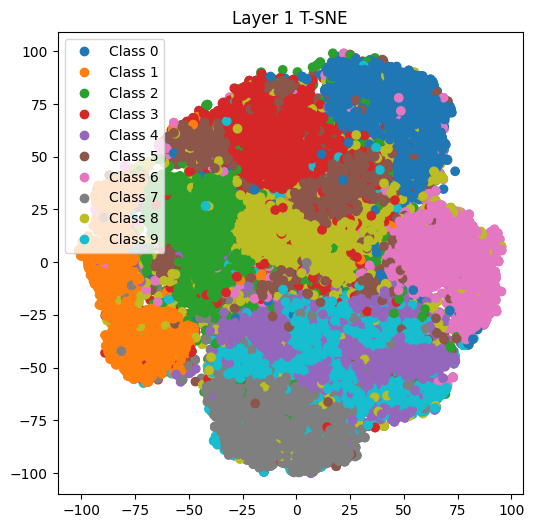

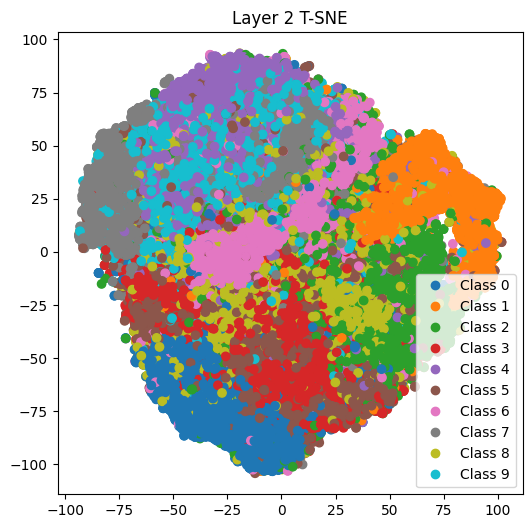

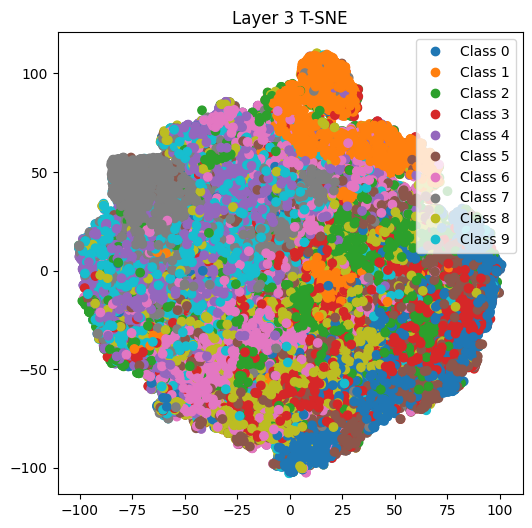

In [41]:
model_untrained = MLP(act=nn.Sigmoid())
plot_tsne(model_untrained)

#### t-SNE embeddings for the trained model

In [43]:
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.long)

# Move model and data to mps for faster training
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = MLP(act=nn.Sigmoid()).to(device)

train_X, train_y = train_X.to(device), train_y.to(device)
test_X, test_y = test_X.to(device), test_y.to(device)

In [44]:
print(device)

mps


In [45]:
losses = train(model, lr=1e-3, epochs=5000, verbose=True)

Epoch 0 Loss: 2.344144821166992
Epoch 500 Loss: 0.5899108052253723
Epoch 1000 Loss: 0.2612855136394501
Epoch 1500 Loss: 0.16360387206077576
Epoch 2000 Loss: 0.11063622683286667
Epoch 2500 Loss: 0.07738432288169861
Epoch 3000 Loss: 0.05477547273039818
Epoch 3500 Loss: 0.03929797187447548
Epoch 4000 Loss: 0.028357461094856262
Epoch 4500 Loss: 0.02069084346294403


Accuracy: 0.9478


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.969636,0.981132,0.953171,0.921271,0.951417,0.916481,0.962769,0.950514,0.935751,0.929000
Accuracy,0.961847,0.977273,0.959725,0.910145,0.945674,0.910398,0.967334,0.957552,0.944561,0.937437
Recall,0.977551,0.985022,0.946705,0.932673,0.957230,0.922646,0.958246,0.943580,0.927105,0.920714


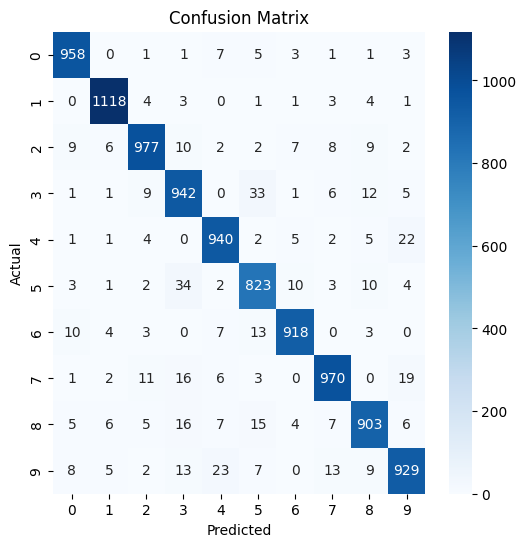

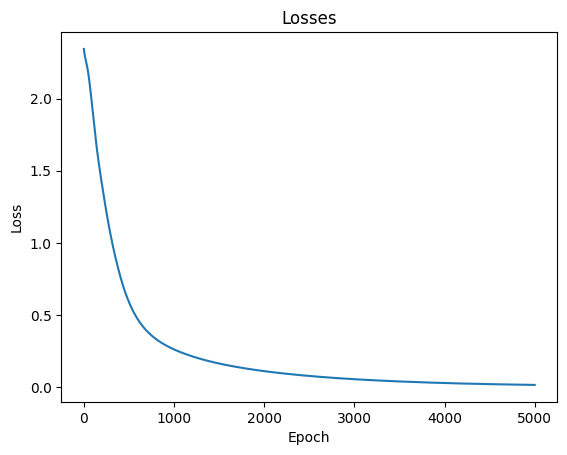

In [46]:
print_metrics(model)
plot_losses(losses)
torch.save(model, './models/MLP.pth')

In [72]:
train_X = train_X.cpu().numpy()
train_y = train_y.cpu().numpy()
test_X = test_X.cpu().numpy()
test_y = test_y.cpu().numpy()

In [73]:
model = torch.load('./models/MLP.pth', map_location='cpu', weights_only=False)
model = model.to('cpu')

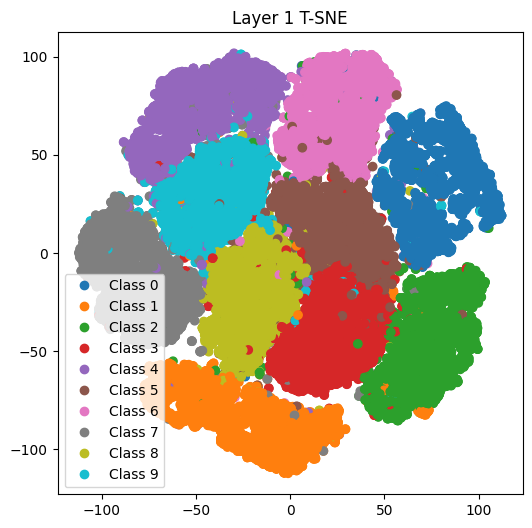

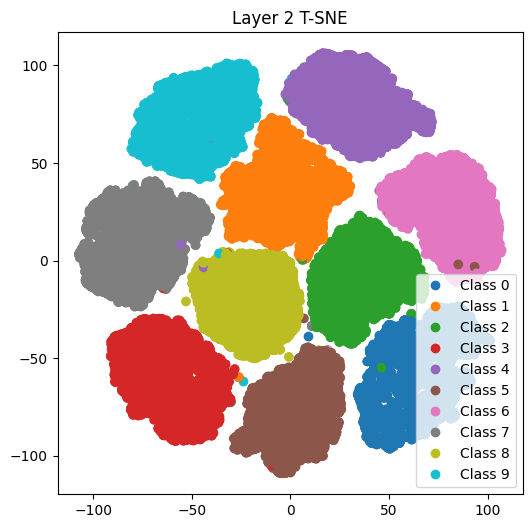

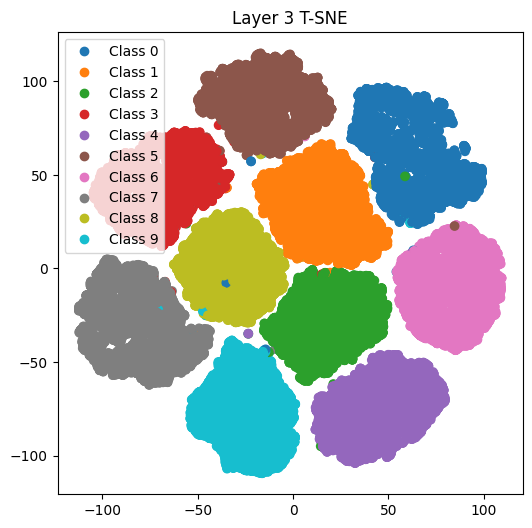

In [75]:
plot_tsne(model)

#### Visualizing the t-SNE embeddings for the input data

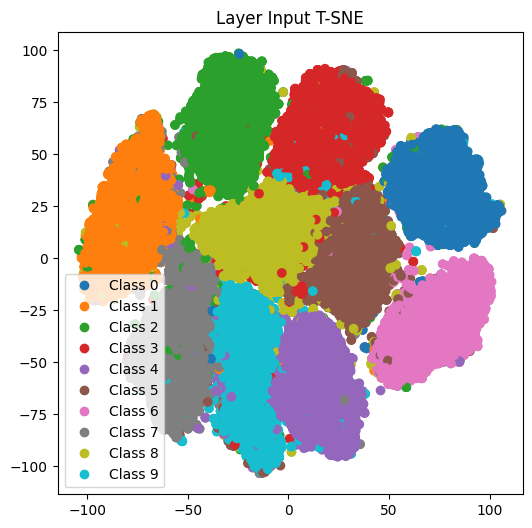

In [76]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(train_X)
plt.figure(figsize=(6, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_y, cmap="tab10")
# print the legend of the classes
legend_labels = [f"Class {label}" for label in range(10)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
plt.title(f"Layer Input T-SNE")
plt.show()

We first visualised the t-SNE embeddings of the untrained model and then the trained model. We can clearly see that in the trained model, the embeddings are more clustered and separated compared to the untrained model. 

From the t-SNE embeddings, we can conclude that the MLP does to good job in learning the features for the MNIST dataset. Initially for the untrained model, it outputs random features, but after training, the embeddings are more clustered and separated.

### Using the trained MLP model to predict on the Fashion-MNIST dataset 
In this section, we used the trained MLP model to predict on the Fashion-MNIST dataset. The Fashion-MNIST dataset consists of 60,000 training images and 10,000 test images. We evaluate the model on the test set and get very bad results. This is expected since the model was trained on the MNIST dataset which consists of handwritten digits and not on the Fashion-MNIST dataset which consists of images of clothing items.

In [77]:
(f_train_X, f_train_y), (f_test_X, f_test_y) = fashion_mnist.load_data()

f_train_X = f_train_X.reshape(-1, 28 * 28)
f_test_X = f_test_X.reshape(-1, 28 * 28)

f_train_X = torch.from_numpy(f_train_X).float() / 255
f_test_X = torch.from_numpy(f_test_X).float() / 255
f_train_y = torch.from_numpy(f_train_y).long()
f_test_y = torch.from_numpy(f_test_y).long()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/var/folders/3m/s02h4sgd74lg5s9ytbmcm02w0000gn/T/ipykernel_36181/3887050459.py:6: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  f_train_X = torch.from_numpy(f_train_X).float() / 255


In [79]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = torch.load('./models/MLP.pth', map_location=device, weights_only=False)
model.to(device)
model.eval()

MLP(
  (l1): Linear(in_features=784, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=10, bias=True)
  (act): Sigmoid()
)

In [ ]:
f_test_X = torch.tensor(f_test_X, dtype=torch.float32).to(device)
f_test_y = torch.tensor(f_test_y, dtype=torch.long).to(device)

In [ ]:
def print_metrics_fmnist(model):

    model.eval()
    # Use no gradient for evaluation
    with torch.no_grad():
		
        # Move test data to MPS
        f_test_X_mps = f_test_X.to('mps')
        f_test_y_mps = f_test_y.to('mps')

        # Forward pass
        outputs = model(f_test_X_mps)
        _, pred = torch.max(outputs, 1)

        # Move results back to CPU for sklearn & numpy
        y_true = f_test_y_mps.cpu().numpy()
        y_pred = pred.cpu().numpy()

        # Accuracy
        acc = (pred == f_test_y_mps).float().mean()
        print(f"Accuracy: {acc.item():.4f}")

        # Confusion matrix & F1
        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average=None)

        # Precision & recall per class
        precisions = []
        recalls = []
        for i in range(10):
            precisions.append(cm[i, i] / (cm[:, i].sum() + 1e-7))
            recalls.append(cm[i, i] / (cm[i].sum() + 1e-7))

        # Table
        df = pd.DataFrame(
            np.array([f1, precisions, recalls]).T,
            index=range(10),
            columns=["F1 Score", "Precision", "Recall"]
        )
        df.index.name = "Class"
        display(df.T)

        # Heatmap
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        return cm

Accuracy: 0.0460


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.025913,0.0,0.042151,0.045288,0.0,0.051663,0.127507,0.019436,0.033058,0.005655
Accuracy,0.021332,0.0,0.027813,0.058360,0.0,0.035620,0.099330,0.344828,0.202247,0.049180
Recall,0.033000,0.0,0.087000,0.037000,0.0,0.094000,0.178000,0.010000,0.018000,0.003000


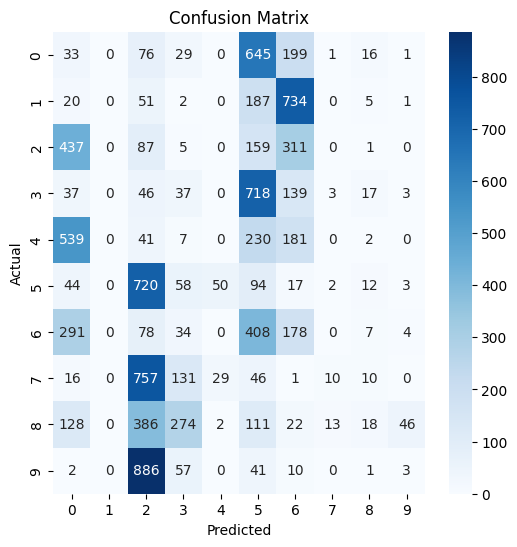

array([[ 33,   0,  76,  29,   0, 645, 199,   1,  16,   1],
       [ 20,   0,  51,   2,   0, 187, 734,   0,   5,   1],
       [437,   0,  87,   5,   0, 159, 311,   0,   1,   0],
       [ 37,   0,  46,  37,   0, 718, 139,   3,  17,   3],
       [539,   0,  41,   7,   0, 230, 181,   0,   2,   0],
       [ 44,   0, 720,  58,  50,  94,  17,   2,  12,   3],
       [291,   0,  78,  34,   0, 408, 178,   0,   7,   4],
       [ 16,   0, 757, 131,  29,  46,   1,  10,  10,   0],
       [128,   0, 386, 274,   2, 111,  22,  13,  18,  46],
       [  2,   0, 886,  57,   0,  41,  10,   0,   1,   3]])

In [87]:
print_metrics_fmnist(model)

In [93]:
model = model.to('cpu')
# f_train_X = f_train_X.to('cpu').numpy()
# f_train_y = f_train_y.to('cpu').numpy()
# f_test_X = f_test_X.to('cpu').numpy()
# f_test_y = f_test_y.to('cpu').numpy()

In [94]:
def plot_tsne_fmnist(model):
	
    f_X_tensor = torch.tensor(f_train_X, dtype=torch.float32).to('cpu')
    feats = model.get_feats(f_X_tensor)

    for i in range(len(feats)):
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(feats[i])
        plt.figure(figsize=(6, 6))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=f_train_y, cmap="tab10")
        legend_labels = [f"Class {label}" for label in range(10)]
        plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
        plt.title(f"Layer {i + 1} T-SNE")
        plt.show()

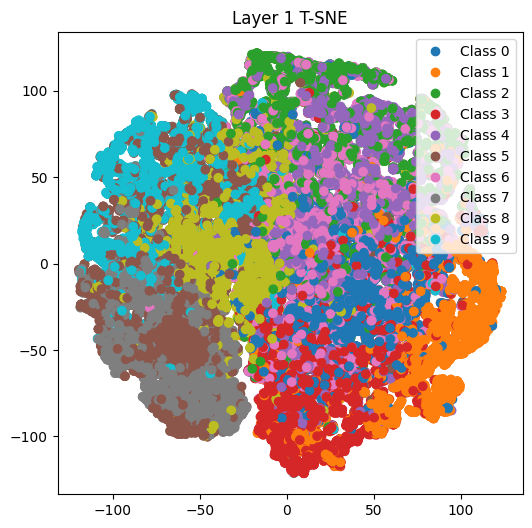

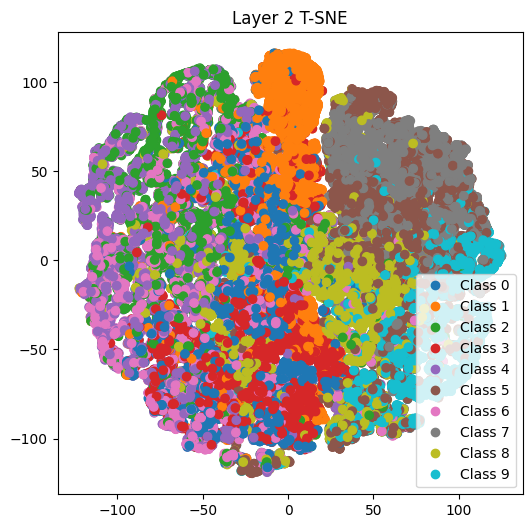

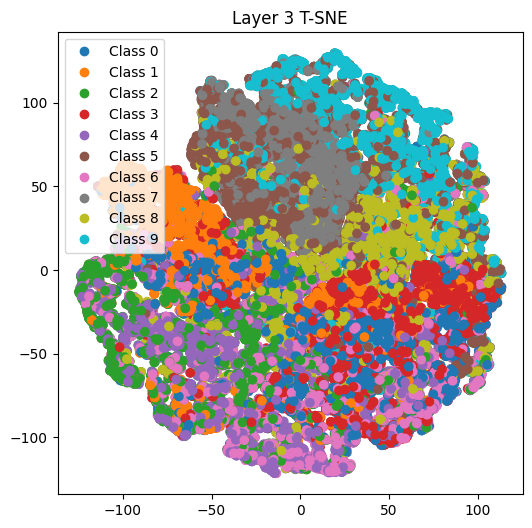

In [95]:
plot_tsne_fmnist(model)

The Fashion MNIST plots of t-SNE embeddings for the layer with 20 neurons is as shown above. The clusters are not well defined and there is a lot of overlap between the different classes. This is expected since the model was not trained on the Fashion-MNIST dataset and hence the features learned by the model are not relevant for this dataset. In contrast, as seen earlier, the t-SNE embeddings for the MNIST dataset had well defined clusters for the different classes.

#### 3.2 Using CNN [1.5 marks]
- Implement a simple CNN with a convolutional layer having 32 filters of size 3x3, a maxpool layer, a fully connected layer with 128 neurons and an output layer with 10 neurons (for the 10 classes) and ReLU activation. Train on MNIST dataset.
- Additionally, use two any pretrained CNNs of your choice (e.g. AlexNet, MobileNet, or EfficientNet) for inference.
- Compare all three models:
	- Accuracy, F1-score, confusion matrix
	- Model size (number of parameters)
	- Inference time on test set

Basic Imports

In [4]:
import time
from torchvision import models, transforms

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


Loading the dataset

In [6]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.reshape(-1, 28 * 28)
test_X = test_X.reshape(-1, 28 * 28)

train_X = torch.tensor(train_X, dtype=torch.float32) / 255.0
test_X = torch.tensor(test_X, dtype=torch.float32) / 255.0

train_y = torch.tensor(train_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)

In [ ]:
def print_metrics_cnn(model, batch_size=64):
    model.eval()
    test_dataset = TensorDataset(test_X.view(-1, 1, 28, 28), test_y)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to('mps')
            y_batch = y_batch.to('mps')

            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    # Accuracy
    acc = (y_pred == y_true).mean()
    print(f"Accuracy: {acc:.4f}")

    # Confusion matrix and F1-score
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)

    precisions = [cm[i, i] / (cm[:, i].sum() + 1e-7) for i in range(10)]
    recalls = [cm[i, i] / (cm[i].sum() + 1e-7) for i in range(10)]

    df = pd.DataFrame(
        np.array([f1, precisions, recalls]).T,
        index=range(10),
        columns=["F1 Score", "Precision", "Recall"]
    )
    df.index.name = "Class"
    display(df.T)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - CNN")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return cm


def print_metrics_efficientnet(model, X, y):
    model.eval()
    all_preds = []
    all_labels = []

    # Create DataLoader to avoid memory overflow
    test_dataset = TensorDataset(X, y)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    # Concatenate results
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    # Overall accuracy
    acc = (y_true == y_pred).mean()
    print(f"Accuracy: {acc:.4f}")

    # Compute confusion matrix and per-class metrics
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)
    precisions = [cm[i, i] / (cm[:, i].sum() + 1e-7) for i in range(10)]
    recalls = [cm[i, i] / (cm[i].sum() + 1e-7) for i in range(10)]

    # Display as DataFrame
    df = pd.DataFrame(
        np.array([f1, precisions, recalls]).T,
        index=range(10),
        columns=["F1 Score", "Precision", "Recall"]
    )
    df.index.name = "Class"
    display(df.T)

    # Confusion matrix heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - EfficientNet")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return cm


def print_metrics_alexnet(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, pred = torch.max(outputs, 1)

        y_true = y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        acc = (pred == y).float().mean().item()
        print(f"Accuracy: {acc:.4f}")

        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average=None)

        precisions = [cm[i, i] / (cm[:, i].sum() + 1e-7) for i in range(10)]
        recalls = [cm[i, i] / (cm[i].sum() + 1e-7) for i in range(10)]

        df = pd.DataFrame(
            np.array([f1, precisions, recalls]).T,
            index=range(10),
            columns=["F1 Score", "Precision", "Recall"]
        )
        df.index.name = "Class"
        display(df.T)

        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix - AlexNet")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        return cm


def plot_losses_cnn(losses):
    plt.plot(losses)
    plt.title("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


def train_cnn(model, lr=0.001, epochs=20, verbose=True, reg=1e-5, batch_size=64):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    train_dataset = TensorDataset(train_X, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device).view(-1, 1, 28, 28)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if verbose and (epoch % max(1, epochs // 10) == 0):
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return losses

### Training and comparing the performance of CNN models for the Handwritten digits classification task

In this section, we implement and compare the performance of three convolutional neural network models for handwritten digit classification using the MNIST dataset.
Simple CNN – a custom model with:
- one convolutional layer (32 filters of size 3×3),
- a max-pooling layer,
- one fully connected layer with 128 neurons, and
- an output layer with 10 neurons (for the 10 digit classes) using ReLU activations.

Pretrained CNNs – two pretrained models (AlexNet and MobileNetV2) are used for inference after fine-tuning or feature extraction.

We will compare the models on:
- Accuracy, F1-score, and Confusion Matrix
- Model size (number of parameters)
- Inference time on the test set

#### Training the CNN model

In this section, we train a simple Convolutional Neural Network (CNN) for the MNIST handwritten digits dataset. The architecture of the CNN is as follows:
- Convolutional layer: 32 filters of size 3×3 with ReLU activation
- Max Pooling layer: 2×2 kernel
- Fully Connected layer: 128 neurons with ReLU activation
- Output layer: 10 neurons (one for each digit class)

We use the Adam optimizer and cross-entropy loss function for training. The ReLU activation function is applied after each layer except the final output layer, where raw logits are passed directly to the loss function.

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input channel (grayscale), 32 output filters, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer with 2x2 window
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer (input size: 32 * 14 * 14)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        # Output layer (10 classes)
        self.fc2 = nn.Linear(128, 10)
        # Activation function
        self.act = nn.ReLU()

    def forward(self, x):
        # x shape: (batch_size, 1, 28, 28)
        x = self.conv1(x)          # (batch_size, 32, 28, 28)
        x = self.act(x)
        x = self.pool(x)           # (batch_size, 32, 14, 14)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 32*14*14)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)            # Output logits
        return x


In [66]:
cnn_model = SimpleCNN().to(device)

losses_cnn = train_cnn( cnn_model, lr=0.001, epochs=50, verbose=True, reg=1e-5 )

Epoch [1/50], Loss: 0.2268
Epoch [6/50], Loss: 0.0220
Epoch [11/50], Loss: 0.0075
Epoch [16/50], Loss: 0.0059
Epoch [21/50], Loss: 0.0035
Epoch [26/50], Loss: 0.0046
Epoch [31/50], Loss: 0.0032
Epoch [36/50], Loss: 0.0025
Epoch [41/50], Loss: 0.0034
Epoch [46/50], Loss: 0.0022


I first trained it on 500 epochs and saw that the model was overfitting after 100-150 epochs. Hence I reduced the number of epochs to 100 and trained the model again. The loss curve and evaluation on the test set are shown below. Then on more closer observation, I saw that the model was still overfitting  after 50 epochs. Hence I reduced the number of epochs to 50 and trained the model again. The final loss curve and evaluation on the test set are shown below.

We see that the loss saturated around 20 epochs  and then was oscillating. The loss is much lower than what we had seen with the MLP model. The accuracy and F1-score on the test set are also significantly better than both the MLP model and the Random Forest model. This is because CNNs are better suited for image data as they can capture spatial hierarchies and local patterns through convolutional layers, leading to improved performance on tasks like handwritten digit recognition.

Accuracy: 0.9839


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.985405,0.994276,0.983575,0.986534,0.986260,0.981027,0.980454,0.985956,0.980977,0.972596
Accuracy,0.972195,0.993838,0.980732,0.993970,0.985758,0.976667,0.992513,0.981678,0.982492,0.977956
Recall,0.998980,0.994714,0.986434,0.979208,0.986762,0.985426,0.968685,0.990272,0.979466,0.967294


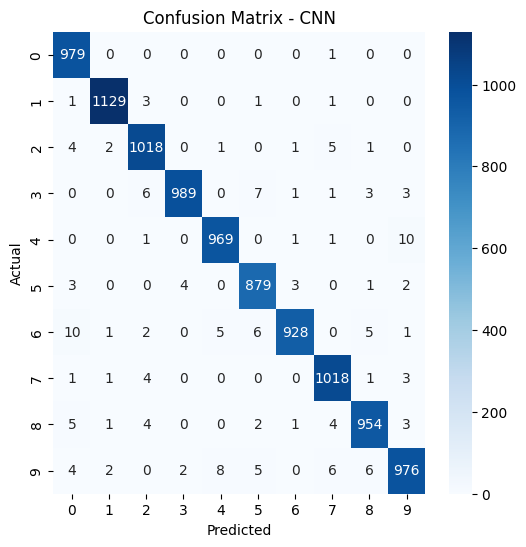

Most commonly confused with 0: [7 9]
Most commonly confused with 1: [2 7]
Most commonly confused with 2: [7 0]
Most commonly confused with 3: [5 2]
Most commonly confused with 4: [9 7]
Most commonly confused with 5: [3 6]
Most commonly confused with 6: [0 5]
Most commonly confused with 7: [2 9]
Most commonly confused with 8: [0 7]
Most commonly confused with 9: [4 8]


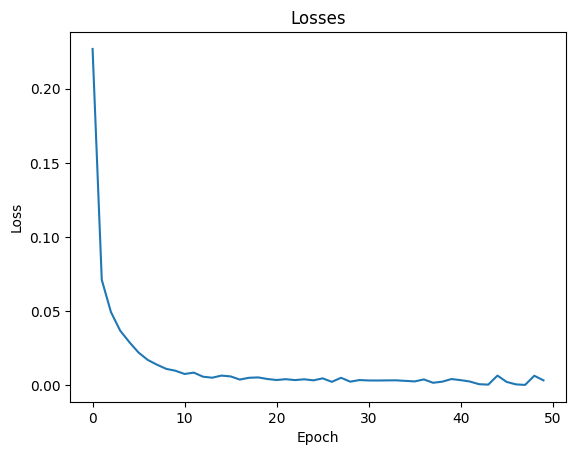

In [69]:
cm = print_metrics_cnn(cnn_model, batch_size=64)
plot_losses_cnn(losses_cnn)

for i in range(10):
    print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

torch.save(cnn_model.to('cpu'), './models/cnn_mnist.pth')

In [72]:
batch_size = 64  
cnn_model = cnn_model.to('mps')
cnn_model.eval()

all_outputs = []
start_time = time.time()

with torch.no_grad():
    for i in range(0, len(test_X), batch_size):
        X_batch = test_X[i:i+batch_size].view(-1, 1, 28, 28).to('mps')
        outputs = cnn_model(X_batch)
        all_outputs.append(outputs.cpu()) 

end_time = time.time()

outputs = torch.cat(all_outputs, dim=0)

inference_time = end_time - start_time
print(f"Inference time on test set: {inference_time:.4f} seconds")

Inference time on test set: 0.4089 seconds


In [73]:
# Count total parameters in SimpleCNN
num_params_cnn = sum(p.numel() for p in cnn_model.parameters())
print(f"CNN model size (number of parameters): {num_params_cnn:,}")

CNN model size (number of parameters): 804,554


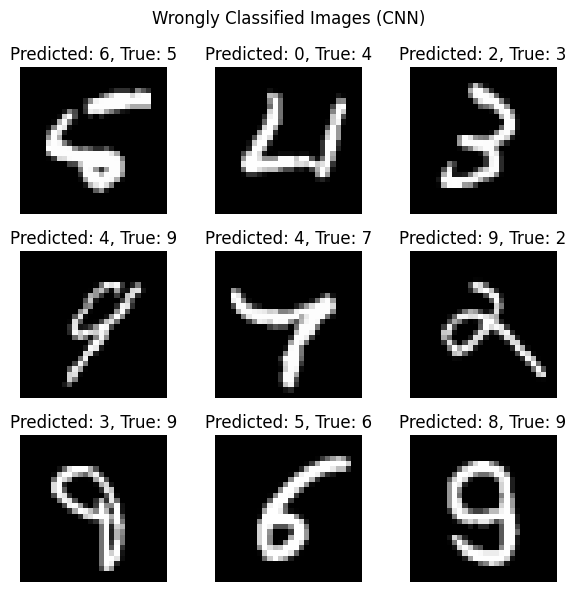

In [27]:
cnn_model = cnn_model.to('mps')
with torch.no_grad():
    X = test_X.view(-1, 1, 28, 28).to('mps')
    y = test_y.to('mps')
    outputs = cnn_model(X)
    _, pred = torch.max(outputs, 1)

pred = pred.cpu()
y = y.cpu()

wrong_idx = (pred != y).nonzero(as_tuple=True)[0]
wrong = test_X[wrong_idx]
wrong_pred = pred[wrong_idx]
wrong_true = y[wrong_idx]

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax[i, j].imshow(wrong[idx].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f"Predicted: {wrong_pred[idx].item()}, True: {wrong_true[idx].item()}")
        ax[i, j].axis('off')

fig.suptitle("Wrongly Classified Images (CNN)")
fig.tight_layout()
plt.show()


#### Using two pretrained CNNs (AlexNet and MobileNetV2) for inference

##### AlexNet

In [31]:
alexnet = models.alexnet(pretrained=True)

alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)

alexnet = alexnet.to(device)

/Users/arinmehta/Documents/GitHub/Machine-Learning/ES335-Assignment3/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/arinmehta/Documents/GitHub/Machine-Learning/ES335-Assignment3/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/arinmehta/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100.0%


In [32]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # make grayscale -> RGB (3 channels)
])

In [34]:
X_test_alex = test_X.view(-1, 1, 28, 28)
# Apply the transform to each image: resize to 224x224 and repeat the single channel to 3 channels because pretrained AlexNet expects 3-channel RGB inputs of size 224x224.
X_test_alex = torch.stack([transform(img) for img in X_test_alex])  # apply one-by-one
X_test_alex = X_test_alex.to(device)
y_test_alex = test_y.to(device)

In [35]:
start_time = time.time()
with torch.no_grad():
    outputs = alexnet(X_test_alex)
inference_time = time.time() - start_time

print(f"Inference time on test set: {inference_time:.4f} seconds")
print(f"Model size (parameters): {sum(p.numel() for p in alexnet.parameters()):,}")

Inference time on test set: 2.7321 seconds
Model size (parameters): 57,044,810


Accuracy: 0.1009


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183305
Accuracy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100900
Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


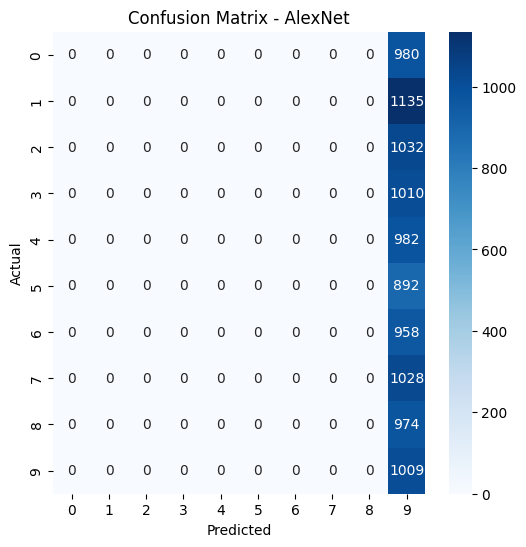

Most commonly confused with 0: [8 7]
Most commonly confused with 1: [8 7]
Most commonly confused with 2: [8 7]
Most commonly confused with 3: [8 7]
Most commonly confused with 4: [8 7]
Most commonly confused with 5: [8 7]
Most commonly confused with 6: [8 7]
Most commonly confused with 7: [8 7]
Most commonly confused with 8: [8 7]
Most commonly confused with 9: [8 7]


In [40]:
cm = print_metrics_alexnet(alexnet, X_test_alex, y_test_alex)

for i in range(10):
    print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

As we can see above, when AlexNet (pretrained on ImageNet) was used directly for inference on the MNIST dataset, the accuracy was around 10%, which is close to random guessing.

The reason for this might be:
- AlexNet was trained on ImageNet, which contains RGB natural images.
- MNIST images are grayscale handwritten digits (1×28×28), very different in texture, scale, and complexity.
- The features learned by AlexNet (like edges, colors, textures) do not transfer well to such simple, monochrome digits.

As we can see, AlexNet takes significantly longer for inference compared to our simple CNN model. This is because AlexNet is a very large model (≈58 million parameters) compared to our simple CNN (≈800 thousand parameters).

Even though MNIST images are simpler, we had to resize them to 224×224×3 to fit AlexNet’s expected input size, which increases computation.

##### EfficientNet

In [47]:
efficientnet = models.efficientnet_b0(pretrained=True)

efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 10)

efficientnet = efficientnet.to(device)

/Users/arinmehta/Documents/GitHub/Machine-Learning/ES335-Assignment3/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/arinmehta/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100.0%


In [49]:
transform_efficientnet = transforms.Compose([
    transforms.Resize((224, 224)),                     
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

In [50]:
X_test_mobile = test_X.view(-1, 1, 28, 28)

# Apply the transform: resize to 224x224 and repeat the single channel to 3 channels because pretrained EfficientNet expects 3-channel RGB inputs of size 224x224.
X_test_efficientnet = torch.stack([transform_efficientnet(img) for img in X_test_mobile])
X_test_efficientnet = X_test_efficientnet.to(device)
y_test_efficientnet = test_y.to(device)

In [52]:
test_dataset = TensorDataset(X_test_efficientnet, y_test_efficientnet)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

start_time = time.time()

# Without batches it was exceeding the RAM limits on MPS
all_outputs = []
with torch.no_grad():
    for images, _ in test_loader:
        outputs = efficientnet(images)
        all_outputs.append(outputs.cpu())

inference_time = time.time() - start_time

print(f"Inference time on test set: {inference_time:.4f} seconds")
print(f"Model size (parameters): {sum(p.numel() for p in efficientnet.parameters()):,}")

Inference time on test set: 240.0284 seconds
Model size (parameters): 4,020,358


Accuracy: 0.0838


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.043134,0.030168,0.059786,0.037422,0.066504,0.007981,0.012206,0.080755,0.154086,0.218415
Accuracy,0.037926,0.024691,0.112601,0.062356,0.055256,0.013850,0.037037,0.087600,0.156283,0.157965
Recall,0.050000,0.038767,0.040698,0.026733,0.083503,0.005605,0.007307,0.074903,0.151951,0.353816


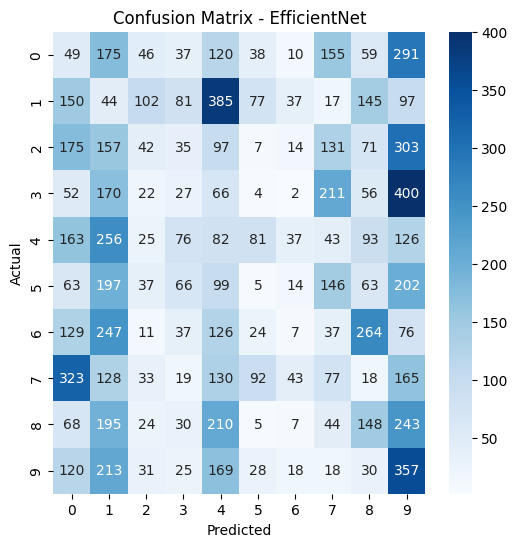

array([[ 49, 175,  46,  37, 120,  38,  10, 155,  59, 291],
       [150,  44, 102,  81, 385,  77,  37,  17, 145,  97],
       [175, 157,  42,  35,  97,   7,  14, 131,  71, 303],
       [ 52, 170,  22,  27,  66,   4,   2, 211,  56, 400],
       [163, 256,  25,  76,  82,  81,  37,  43,  93, 126],
       [ 63, 197,  37,  66,  99,   5,  14, 146,  63, 202],
       [129, 247,  11,  37, 126,  24,   7,  37, 264,  76],
       [323, 128,  33,  19, 130,  92,  43,  77,  18, 165],
       [ 68, 195,  24,  30, 210,   5,   7,  44, 148, 243],
       [120, 213,  31,  25, 169,  28,  18,  18,  30, 357]])

In [58]:
print_metrics_efficientnet(efficientnet, X_test_efficientnet, y_test_efficientnet)

The total inference time for EfficientNet was 240.03 seconds, and the model has around 4 million parameters.

The inference time is significantly higher compared to our simple CNN and AlexNetbecause EfficientNet is a deeper and more complex architecture, containing many convolutional blocks with compound scaling (depth, width, and resolution). Even though AlexNet has more parameters, EfficientNet's layers involve more computationally expensive operations such as depthwise-separable convolutions and squeeze-excite blocks and we also had to calculate on batched inputs.

The input images were resized to 224×224×3 to match EfficientNet’s expected input, which greatly increases the number of pixels processed compared to the original 28×28 grayscale MNIST images.

The poor accuracy (0.0838) is because the pretrained weights are optimized for ImageNet’s natural RGB images, not simple handwritten digits.

| Model | Parameters | Inference Time (s) | Accuracy | Avg. F1 Score |
|:------|:------------:|:------------------:|:----------:|:--------------:|
| Simple CNN | 804,554 | 0.4089 | 0.9839 | 0.9837 |
| AlexNet (pretrained) | 57,044,810 | 2.7321 | 0.1009 | 0.0183 |
| EfficientNet-B0 (pretrained) | 4,020,358 | 240.0284 | 0.0838 | 0.071 |